In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
import tensorflow as tf
import seaborn as sns

from matplotlib import image
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Suppress keras warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
def load_metadata(data_folder, train_file, validation_file, test_file, column_names):
    """Reads the .csv files containing metadata (e.g. file location, class label) about the data images.
    
    Parameters:
    data_folder (str): file path to the folder containing the csv file.
    train_file (str): file name of the file containing metadata for the training set.
    validation_file (str): file name of the file containing metadata for the validation set.
    test_file (str): file name of the file containing metadata for the test set.
    column_names (list): array containing the column names for the csv files
    
    Returns:
    the read trainig, validation, and test files.
    """
    training_df = pd.read_csv(data_folder + train_file, names = column_names, skiprows=1)
    validation_df = pd.read_csv(data_folder + validation_file, names = column_names, skiprows=1)
    test_df = pd.read_csv(data_folder + test_file, names = column_names, skiprows=1)
    
    return training_df, validation_df, test_df

In [3]:
input_folder = "/kaggle/input/"
dataset_folder = input_folder + "eurosat-dataset/" + "EuroSAT/"
column_names =  ["id", "path", "class_id", "class_name"]

training_df, validation_df, test_df = load_metadata(dataset_folder,
                                                    "train.csv",
                                                    "validation.csv",
                                                    "test.csv",
                                                    column_names)

In [4]:
# Take a quick look at the dataframe containing metadata information:
print("Head of the training data frame")
training_df[0:5]

Head of the training data frame


,id,path,class_id,class_name
0,16257,AnnualCrop/AnnualCrop_142.jpg,0,AnnualCrop
1,3297,HerbaceousVegetation/HerbaceousVegetation_2835...,2,HerbaceousVegetation
2,17881,PermanentCrop/PermanentCrop_1073.jpg,6,PermanentCrop
3,2223,Industrial/Industrial_453.jpg,4,Industrial
4,4887,HerbaceousVegetation/HerbaceousVegetation_1810...,2,HerbaceousVegetation


In [5]:
training_df_size = len(training_df)
validation_df_size = len(validation_df)
test_df_size = len(test_df)

total_dataset_size = training_df_size + validation_df_size + test_df_size

print(f"Training set size: {training_df_size} ({round(training_df_size / total_dataset_size * 100)}%)")
print(f"Validation set size: {validation_df_size} ({round(validation_df_size / total_dataset_size * 100)}%)")
print(f"Test set size: {test_df_size} ({round(test_df_size / total_dataset_size * 100)}%)")

print(training_df_size+validation_df_size+test_df_size)

Training set size: 18900 (70%)
Validation set size: 5400 (20%)
Test set size: 2700 (10%)
27000


In [6]:
# The data is already normalized so that pixels values range from 0,255. We can rescale pixel value between
# [0,1] by divinding by 255.

rescaling_factor = 1. / 255
# Generate batches of tensor image data by setting up the generators.
# If you want to perform augmentation, add parameters to the training_generatorF
training_generator = ImageDataGenerator(rescale=rescaling_factor)
test_generator = ImageDataGenerator(rescale=rescaling_factor)

# Size of input data is 64x64 pixels
image_width, image_height = (64, 64)

batch_size = 128 # How big of a set of data to use for every training epoch
# 128 is a pretty standard value


## Build train, validation, and test sets

In [7]:
print("Building training set.")
training_set = training_generator.flow_from_dataframe(
    dataframe=training_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False, #for replicability. Anyways they are already shuffled?
)

print("\n Building validation set.")
validation_set = test_generator.flow_from_dataframe(
    dataframe=validation_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
)

print("\n Building test set")
test_set = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Building training set.
Found 18900 validated image filenames belonging to 10 classes.

 Building validation set.
Found 5400 validated image filenames belonging to 10 classes.

 Building test set
Found 2700 validated image filenames belonging to 10 classes.


## Some data inspection

AnnualCrop              2100
Forest                  2100
HerbaceousVegetation    2100
Highway                 1750
Industrial              1750
Pasture                 1400
PermanentCrop           1750
Residential             2100
River                   1750
SeaLake                 2100
dtype: int64


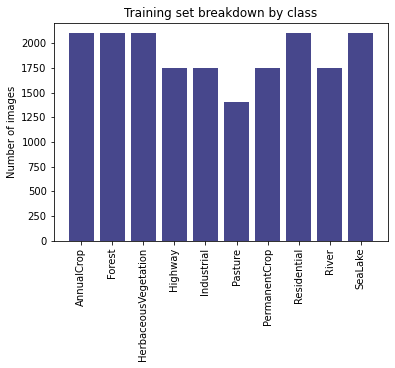

In [8]:
class_name_list = np.array(list(training_set.class_indices.keys()))
labels, count = np.unique(training_set.classes, return_counts=True)

print(pd.Series(count, index=class_name_list))

objects = class_name_list
y_pos = np.arange(len(objects))
n_images = count

plt.bar(y_pos, n_images, align='center', alpha=0.8, color="midnightblue")
plt.xticks(y_pos, class_name_list, rotation=90)
plt.ylabel('Number of images')
plt.title('Training set breakdown by class')

#plt.show()
plt.savefig("/kaggle/working/exp1_train_classes.png")

AnnualCrop              600
Forest                  600
HerbaceousVegetation    600
Highway                 500
Industrial              500
Pasture                 400
PermanentCrop           500
Residential             600
River                   500
SeaLake                 600
dtype: int64


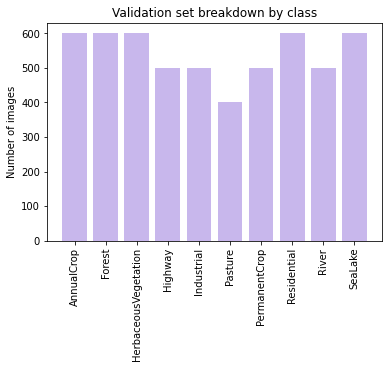

In [9]:
val_class_name_list = np.array(list(validation_set.class_indices.keys()))
val_labels, val_count = np.unique(validation_set.classes, return_counts=True)

print(pd.Series(val_count, index=val_class_name_list))

val_objects = val_class_name_list
val_y_pos = np.arange(len(val_objects))
val_n_images = val_count

plt.bar(val_y_pos, val_n_images, align='center', alpha=0.5, color="mediumpurple")
plt.xticks(val_y_pos, val_class_name_list, rotation=90)
plt.ylabel('Number of images')
plt.title('Validation set breakdown by class')

#plt.show()
plt.savefig("/kaggle/working/exp1_val_classes.png")

AnnualCrop              300
Forest                  300
HerbaceousVegetation    300
Highway                 250
Industrial              250
Pasture                 200
PermanentCrop           250
Residential             300
River                   250
SeaLake                 300
dtype: int64


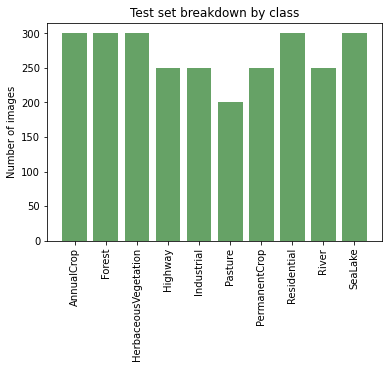

In [10]:
test_class_name_list = np.array(list(test_set.class_indices.keys()))
test_labels, test_count = np.unique(test_set.classes, return_counts=True)

print(pd.Series(test_count, index=test_class_name_list))

test_objects = test_class_name_list
test_y_pos = np.arange(len(test_objects))
test_n_images = test_count

plt.bar(test_y_pos, test_n_images, align='center', alpha=0.6, color="darkgreen")
plt.xticks(test_y_pos, test_class_name_list, rotation=90)
plt.ylabel('Number of images')
plt.title('Test set breakdown by class')

# plt.show()
plt.savefig("/kaggle/working/exp1_test_classes.png")

### Plot an image for each class for visual inspection

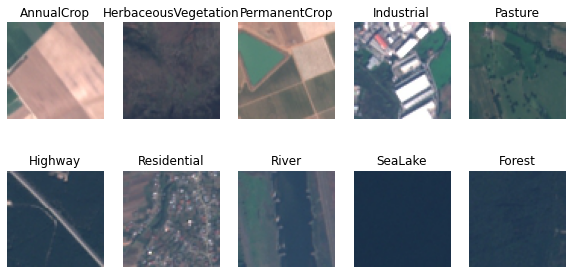

In [11]:
figure_height = 2
figure_width = 5
figure_size = (10, 5)

images, class_ids = next(training_set)
plt.figure(figsize=figure_size)
already_used_labels = []

imgs_to_plot = []
labels_to_plot = []

# Pick an image for each category from the training test:

while len(imgs_to_plot) < 9:
    for idx in range(len(images)):
        if class_name_list[class_ids[idx].astype(bool)][0] in already_used_labels:
            pass
        else:
            imgs_to_plot.append(images[idx])
            labels_to_plot.append(class_name_list[class_ids[idx].astype(bool)][0])
            already_used_labels.append(class_name_list[class_ids[idx].astype(bool)][0])

for index in range(figure_height * figure_width):
    plt.subplot(figure_height, figure_width, index + 1)
    plt.imshow(imgs_to_plot[index])
    plt.title(labels_to_plot[index])
    plt.axis("off")

plt.savefig("/kaggle/working/images_examples.png")

# CNNs

## VGG16
Use pre-trained weight as they work better than randomly initializing them.
**You can experiment with that as well.**

In [12]:
base_vgg16 = VGG16(include_top=False, # do not include the 3 fully-connected layers at the top.
                   # Mandatory because input shape is different from original 224x224x3
                   weights='imagenet', # else None= random initialization
                   input_tensor=None,
                   input_shape=(64, 64, 3),
                   pooling=None,
                   classes=10,
                   classifier_activation='softmax')

58900480/58889256 [==============================] - 0s 0us/step


In [13]:
# base_vgg16.summary()

In [14]:
"""tf.keras.utils.plot_model(
    base_vgg16,
    to_file="vgg16_model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=60, # increase for bigger size image
)"""

'tf.keras.utils.plot_model(\n    base_vgg16,\n    to_file="vgg16_model.png",\n    show_shapes=True,\n    show_dtype=True,\n    show_layer_names=True,\n    rankdir="TB",\n    expand_nested=False,\n    dpi=60, # increase for bigger size image\n)'

## Add custom layers to VGG16
From https://www.kaggle.com/code/rnogueras/keras-basic-toolbox-for-image-recognition/notebook:

For the final layers of the architecture we add:
- **dropout layer** to prevent overfitting of the convolutional base. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.
- a **He normal initializer** for the weights of the dense layer. It draws samples from a truncated normal distribution centered on 0 with stddev = sqrt(2 / fan_in) where fan_in is the number of input units in the weight tensor.
- a **Softmax function** to produce the multiclass output.

In [15]:
class_count = len(class_name_list)
model = Sequential()
model.add(base_vgg16)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=512, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(class_count, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 15,768,906
Trainable params: 15,768,906
Non-trainable params: 0
_________________________________________________________________


### Some improvements and Speed-ups:
**ModelCheckpoint**: Save the weigths of the best model

**ReduceLROnPlateau**: Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

**EarlyStopping**: Stop training when a monitored metric has stopped improving.

In [16]:
model_path = "/kaggle/working/eurosat_rgb_vgg16_model.h5"

# Save the weigths of the best model
checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", save_best_only=True)

# Reduce learning rate when val_loss stops improving for 5 epochs.
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)

# Stop training if a val_loss has stopped improving for 5 epochs.
early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=True)

callback_list = [checkpoint, early_stopping, reduce_lr]

In [17]:
model.compile(loss="categorical_crossentropy",
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])

#tf.keras.metrics.Precision(),
#tf.keras.metrics.Recall()

In [18]:
history = model.fit(
    training_set,
    validation_data=validation_set,
    callbacks=callback_list,
    epochs=100,
    verbose=1,
)

Epoch 1/100
148/148 [==============================] - 92s 526ms/step - loss: 0.6579 - accuracy: 0.7735 - val_loss: 0.2547 - val_accuracy: 0.9157
Epoch 2/100
148/148 [==============================] - 29s 194ms/step - loss: 0.2113 - accuracy: 0.9305 - val_loss: 0.1689 - val_accuracy: 0.9419
Epoch 3/100
148/148 [==============================] - 28s 189ms/step - loss: 0.1470 - accuracy: 0.9513 - val_loss: 0.1905 - val_accuracy: 0.9380
Epoch 4/100
148/148 [==============================] - 28s 188ms/step - loss: 0.1065 - accuracy: 0.9635 - val_loss: 0.1800 - val_accuracy: 0.9494
Epoch 5/100
148/148 [==============================] - 28s 189ms/step - loss: 0.0931 - accuracy: 0.9702 - val_loss: 0.1590 - val_accuracy: 0.9537
Epoch 6/100
148/148 [==============================] - 28s 187ms/step - loss: 0.0620 - accuracy: 0.9802 - val_loss: 0.1802 - val_accuracy: 0.9481
Epoch 7/100
148/148 [==============================] - 28s 188ms/step - loss: 0.0775 - accuracy: 0.9739 - val_loss: 0.1157 -

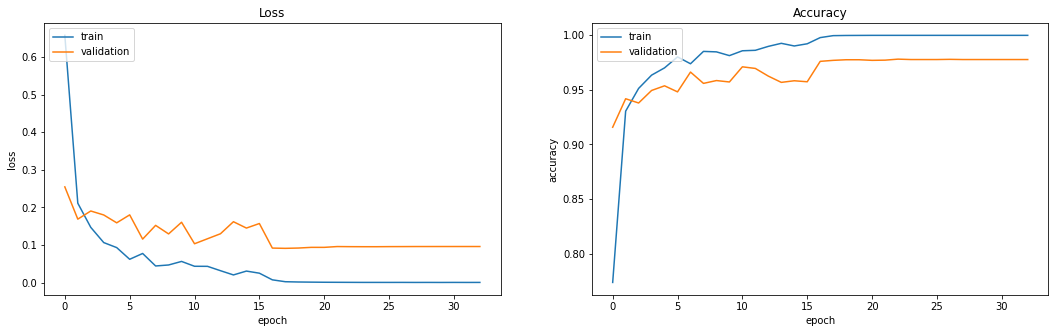

<Figure size 432x288 with 0 Axes>

In [19]:
plt.figure(figsize=(18, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")

plt.show()
plt.savefig("/kaggle/working/exp1_loss_accuracy.png")

The gap between training and validation accuracy indicates some level of overfitting. I could:
- try to **fit a simpler model** and see if that reduces the gap.
- Use [regularizers](https://keras.io/api/layers/regularizers/). Regularizers allow you to apply penalties on layer parameters or layer activity during optimization. These penalties are summed into the loss function that the network optimizes.

# Evaluate Model

In [20]:
loss, accuracy = model.evaluate(test_set, verbose=1)

22/22 [==============================] - 11s 519ms/step - loss: 0.0811 - accuracy: 0.9800


# Predict Test Set

In [21]:
test_set.n

2700

In [22]:
test_set.reset()
predicted_probabilities = model.predict(test_set, steps=test_set.n, verbose=1)
# Computation is done in batches.
predicted_class_ids = np.argmax(predicted_probabilities, axis=1)

2700/2700 [==============================] - 3s 1ms/step


In [23]:
print(metrics.classification_report(test_set.labels, predicted_class_ids, digits=4))

              precision    recall  f1-score   support

           0     0.9764    0.9667    0.9715       300
           1     0.9770    0.9900    0.9834       300
           2     0.9538    0.9633    0.9585       300
           3     0.9843    1.0000    0.9921       250
           4     0.9920    0.9960    0.9940       250
           5     0.9749    0.9700    0.9724       200
           6     0.9590    0.9360    0.9474       250
           7     1.0000    0.9967    0.9983       300
           8     0.9799    0.9760    0.9780       250
           9     1.0000    1.0000    1.0000       300

    accuracy                         0.9800      2700
   macro avg     0.9797    0.9795    0.9796      2700
weighted avg     0.9800    0.9800    0.9800      2700



In [24]:
cf_matrix = confusion_matrix(test_set.labels, predicted_class_ids)
print(cf_matrix)

[[290   1   0   0   0   1   6   0   2   0]
 [  0 297   0   0   0   1   0   0   2   0]
 [  0   5 289   0   0   2   4   0   0   0]
 [  0   0   0 250   0   0   0   0   0   0]
 [  0   0   0   1 249   0   0   0   0   0]
 [  1   0   4   0   0 194   0   0   1   0]
 [  5   0  10   0   0   1 234   0   0   0]
 [  0   0   0   0   1   0   0 299   0   0]
 [  1   1   0   3   1   0   0   0 244   0]
 [  0   0   0   0   0   0   0   0   0 300]]


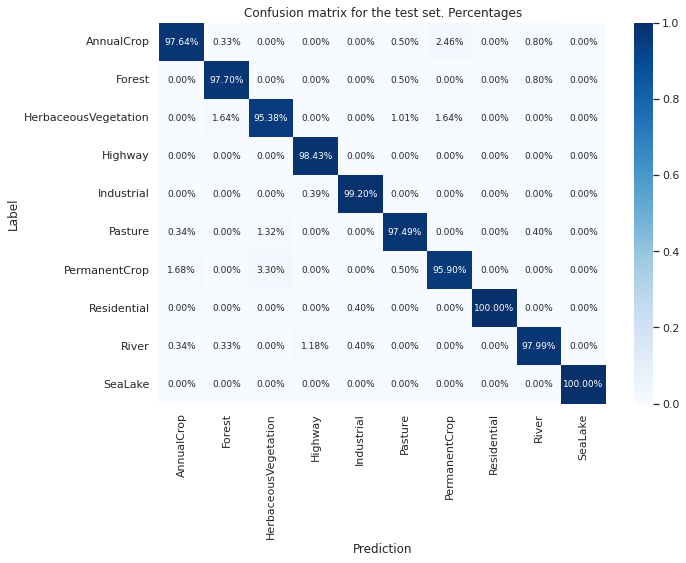

<Figure size 432x288 with 0 Axes>

In [25]:
confusion_matrix_array = confusion_matrix(y_true=test_set.labels, y_pred=predicted_class_ids)
confusion_matrix_df = pd.DataFrame(
    data=confusion_matrix_array, 
    index=class_name_list, 
    columns=class_name_list
)

plt.figure(figsize=(10, 7))
sns.set(font_scale=1)
sns.heatmap(confusion_matrix_df/np.sum(confusion_matrix_df), annot=True,
           cmap="Blues", annot_kws={"size": 9}, fmt='.2%')
plt.ylabel("Label")
plt.xlabel("Prediction")
plt.title("Confusion matrix for the test set. Percentages")
plt.show()
plt.savefig("/kaggle/working/exp1_confusion_percentages.png")

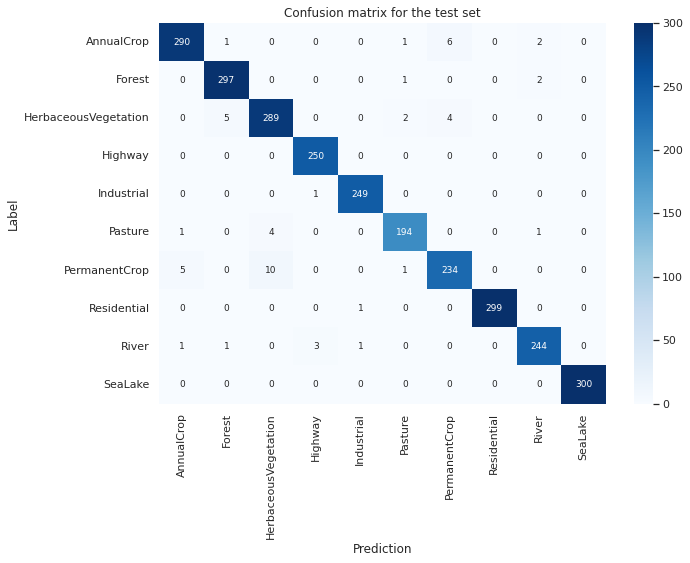

<Figure size 432x288 with 0 Axes>

In [26]:
plt.figure(figsize=(10, 7))
sns.set(font_scale=1)
sns.heatmap(confusion_matrix_df, annot=True, cmap="Blues", annot_kws={"size": 9}, fmt="g")
plt.ylabel("Label")
plt.xlabel("Prediction")
plt.title("Confusion matrix for the test set")
plt.show()
plt.savefig("/kaggle/working/exp1_confusion.png")

In [27]:
results_df = pd.DataFrame(
    {
        "label": test_set.labels, 
        "prediction": predicted_class_ids, 
        "path": test_set.filepaths
    }
)


### Plot wrong predictions

In [28]:
mistakes = results_df["label"] != results_df["prediction"]
mistakes_df = results_df[mistakes]

print(f"{len(mistakes_df)} wrong predictions out of {len(results_df)}")

54 wrong predictions out of 2700


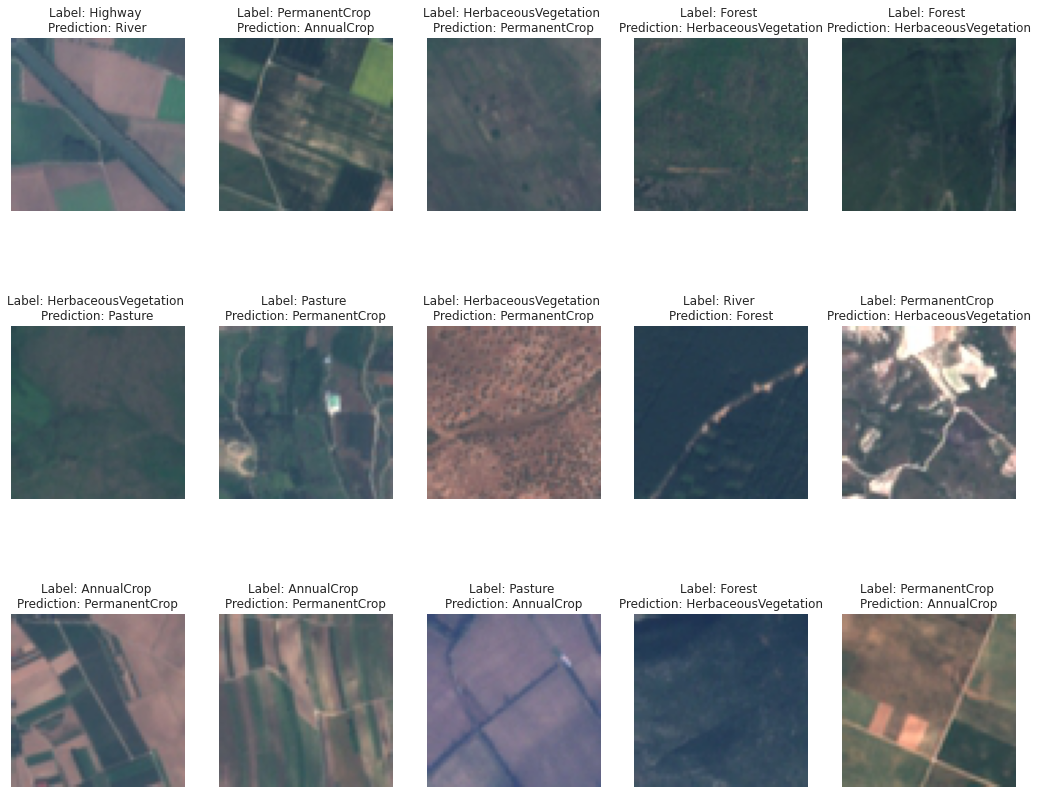

In [29]:
mistaken_predictions = (class_name_list[pred] for pred in mistakes_df["prediction"])
mistaken_labels = (class_name_list[label] for label in mistakes_df["label"])
mistaken_images = (image.imread(path) for path in mistakes_df["path"])

figure_height = 3
figure_width = 5

figure_size = (18, 15)
plt.figure(figsize=figure_size)
for index in range(figure_height * figure_width):
    
    label = next(mistaken_predictions)
    prediction = next(mistaken_labels)
    picture = next(mistaken_images)
    
    plt.subplot(figure_height, figure_width, index + 1)
    plt.imshow(picture)
    plt.title(f"Label: {label} \nPrediction: {prediction}")
    plt.axis("off")

plt.savefig("/kaggle/working/exp1_mislabeled_results.png")